# Electricity Demand Prediction

## Introduction

In this notebook, I analyzed daily electricity demand data using three different **time series** forecasting models: ARIMA, Prophet, and LSTM.

Through this project, I gained valuable insights into the strengths and limitations of each model, learned how to preprocess and visualize time series data, and developed a deeper understanding of time series forecasting techniques.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load Data

data = pd.read_csv('/content/drive/My Drive/Data_Science/complete_dataset.csv', parse_dates=['date'], index_col='date')

# Display the first few rows of the dataset
data.head()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## Data Preprocessing

In [4]:
# Checking for missing values
data.isnull().sum()

demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

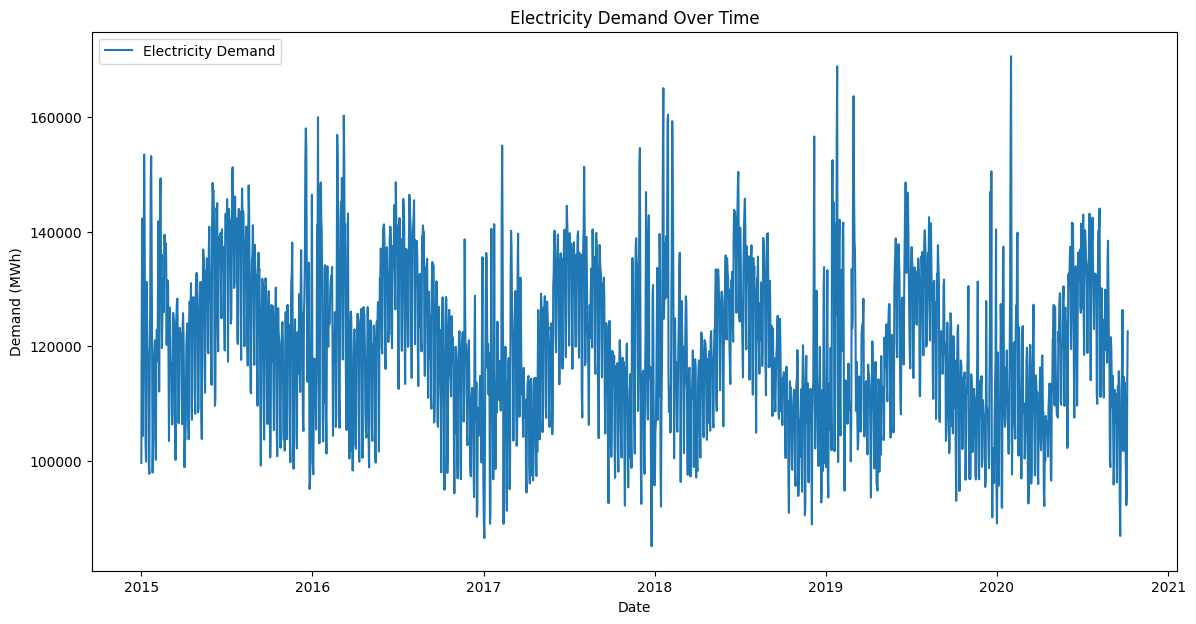

In [5]:
# Fill or drop missing values
data = data.fillna(method='ffill')

# Visualizing the Data

plt.figure(figsize=(14, 7))
plt.plot(data['demand'], label='Electricity Demand')
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

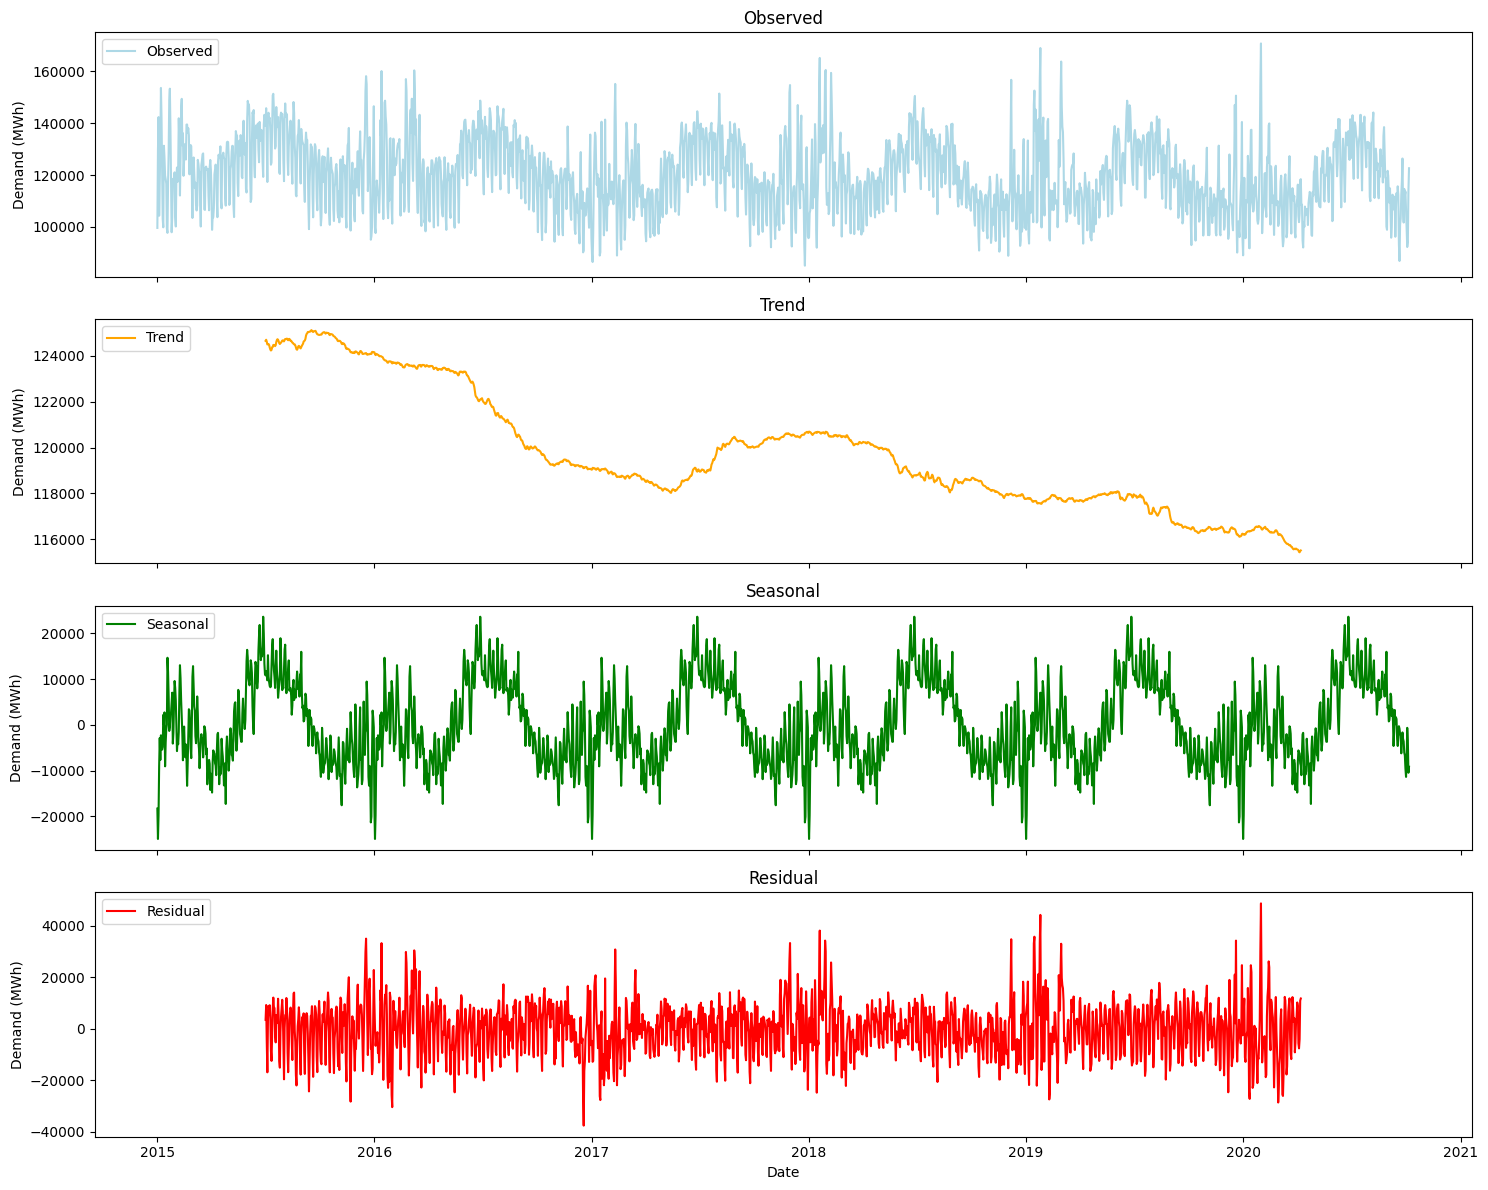

In [6]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(data['demand'], model='additive', period=365)

# Extract the components
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a custom plot
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plot observed data
axes[0].plot(observed, label='Observed', color='lightblue')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Demand (MWh)')
axes[0].set_title('Observed')
# Plot trend component
axes[1].plot(trend, label='Trend', color='orange')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('Demand (MWh)')
axes[1].set_title('Trend')

# Plot seasonal component
axes[2].plot(seasonal, label='Seasonal', color='green')
axes[2].legend(loc='upper left')
axes[2].set_ylabel('Demand (MWh)')
axes[2].set_title('Seasonal')

# Plot residual component
axes[3].plot(residual, label='Residual', color='red')
axes[3].legend(loc='upper left')
axes[3].set_ylabel('Demand (MWh)')
axes[3].set_title('Residual')

# Set x-axis label
axes[3].set_xlabel('Date')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()



> I performed **seasonal decomposition** to break down the electricity demand data into its underlying components: trend, seasonality, and residuals. This analysis helps us understand the long-term trend, identify recurring seasonal patterns, and isolate irregular fluctuations. By separating these components, we can gain clearer insights into the behavior of the data, which aids in building more accurate forecasting models.



## ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


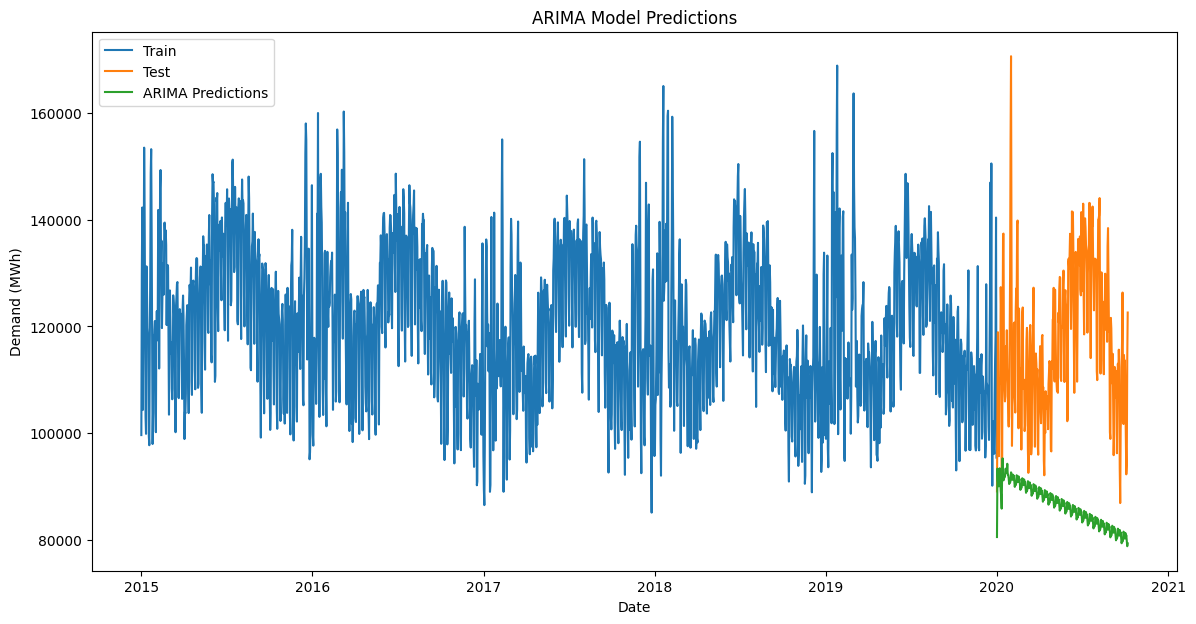

In [7]:
# Splitting the data into training and test sets
train_data = data[:'2019']
test_data = data['2020':]

# Fitting the ARIMA model
arima_model = SARIMAX(train_data['demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_result = arima_model.fit(disp=False)

# Making predictions
arima_pred = arima_result.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data['demand'], label='Train')
plt.plot(test_data['demand'], label='Test')
plt.plot(arima_pred, label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()



> Let's use grid search to find the optimal parameters for the ARIMA model. This involves testing different combinations of p, d, q, and seasonal parameters to find the best fit.



In [8]:
!pip install pmdarima

In [9]:
import pmdarima as pm

auto_model = pm.auto_arima(train_data['demand'], seasonal=True, m=12,
                           start_p=0, start_q=0, max_p=3, max_q=3,
                           start_P=0, start_Q=0, max_P=3, max_Q=3,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=40506.781, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=39959.017, Time=2.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=15.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=40499.671, Time=0.47 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=39717.769, Time=10.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=39575.970, Time=19.58 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=32.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.64 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=39204.494, Time=7.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=39473.330, Time=4.60 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=25.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=12.52 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=39552.702, Time=14.12 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=39439.095, Time=32.26 sec
 ARIMA(0,1,0)(3,1,0)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1826
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood              -19598.247
Date:                            Tue, 18 Jun 2024   AIC                          39204.494
Time:                                    05:56:11   BIC                          39226.505
Sample:                                01-01-2015   HQIC                         39212.616
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9518      0.017    -55.697      0.000      -0.985      -0.918
ar.S.L24      -0.7609      0.020    -38.619      0.000      -0.799      -0.722
ar.S.L36      -0.3756      0.018    -20.535      0.000      -0.411      -0.340
sigma2      1.394e+08   8.76e-12   1.59e+19      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   8.86   Jarque-Bera (JB):                93.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.10
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+34. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


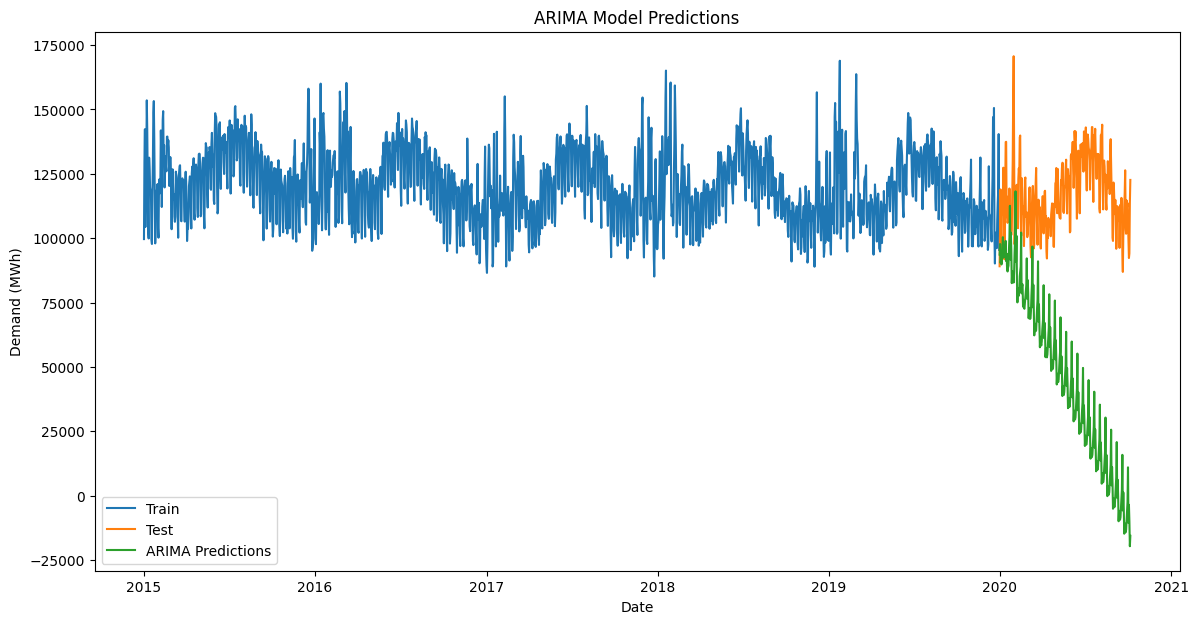

In [10]:
# Splitting the data into training and test sets again for completeness
train_data = data[:'2019']
test_data = data['2020':]

# Fitting the best ARIMA model
best_arima_model = SARIMAX(train_data['demand'],
                           order=(0, 1, 0),
                           seasonal_order=(3, 1, 0, 12))
best_arima_result = best_arima_model.fit(disp=False)

# Making predictions
arima_pred = best_arima_result.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data['demand'], label='Train')
plt.plot(test_data['demand'], label='Test')
plt.plot(arima_pred, label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()



> Since the ARIMA model's performance was not satisfactory, we will incorporate additional variables such as temperature, solar exposure, and rainfall into the model as exogenous variables. These factors can significantly influence electricity demand, and including them can help improve the accuracy of our predictions.



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


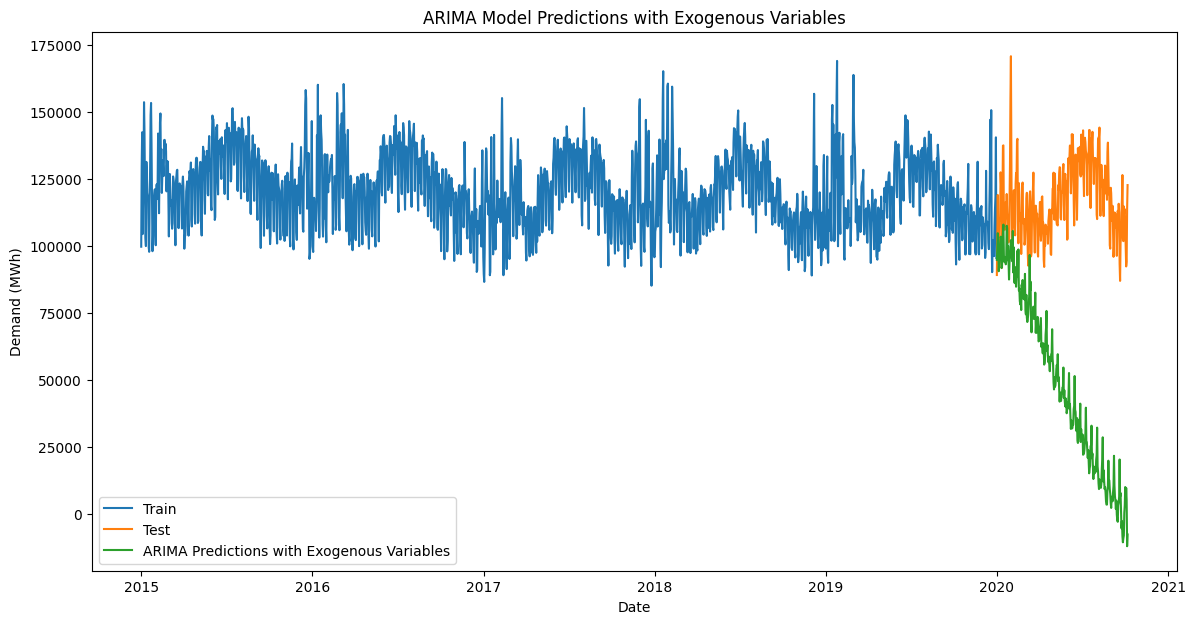

MAE: 69115.31048159626
MSE: 6216670429.013236
RMSE: 78845.86500897327


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare exogenous variables
exog_train = train_data[['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']]
exog_test = test_data[['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']]

# Fit the SARIMAX model with exogenous variables
arima_model_exog = SARIMAX(train_data['demand'],
                           exog=exog_train,
                           order=(0, 1, 0),
                           seasonal_order=(3, 1, 0, 12))
arima_result_exog = arima_model_exog.fit(disp=False)

# Making predictions with exogenous variables
arima_pred_exog = arima_result_exog.predict(start=test_data.index[0],
                                            end=test_data.index[-1],
                                            exog=exog_test,
                                            dynamic=False)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data['demand'], label='Train')
plt.plot(test_data['demand'], label='Test')
plt.plot(arima_pred_exog, label='ARIMA Predictions with Exogenous Variables')
plt.title('ARIMA Model Predictions with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# Evaluating the model
mae = mean_absolute_error(test_data['demand'], arima_pred_exog)
mse = mean_squared_error(test_data['demand'], arima_pred_exog)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')



> Given that the ARIMA model is not performing well with the electricity demand data, likely due to its inability to capture complex, non-linear relationships and interactions with exogenous variables, switching to a different model is a reasonable next step. This approach can potentially provide better predictions and insights by leveraging the strengths of machine learning techniques.



## Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqrxyznz/31c3lrwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqrxyznz/oyrf4tdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17722', 'data', 'file=/tmp/tmpiqrxyznz/31c3lrwk.json', 'init=/tmp/tmpiqrxyznz/oyrf4tdk.json', 'output', 'file=/tmp/tmpiqrxyznz/prophet_model0knf37cg/prophet_model-20240618055659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 6906.180937616116
MSE: 78926056.83765896
RMSE: 8884.033815652603
MAPE: 5.98%
Mean Demand: 120035.47650284901
MAE as a Percentage of Mean Demand: 5.75%
RMSE as a Percentage of Mean Demand: 7.40%


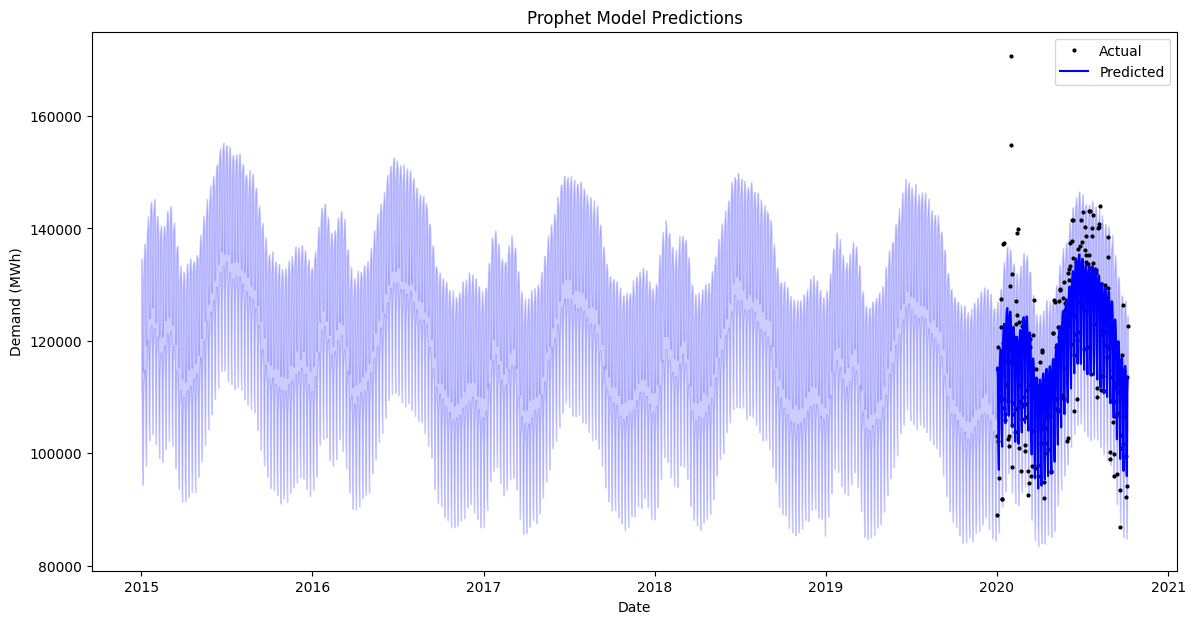

In [12]:
# Preparing the data for Prophet
prophet_data = data.reset_index().rename(columns={'date': 'ds', 'demand': 'y'})

# Splitting the data
prophet_train = prophet_data[prophet_data['ds'] < '2020']
prophet_test = prophet_data[prophet_data['ds'] >= '2020']

# Fitting the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Making future dataframe and predictions
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='D')
prophet_pred = prophet_model.predict(future)

# Extract actual values from the test set
test_data_actual = prophet_test['y'].values

# Extract predicted values from the Prophet model
prophet_pred_values = prophet_pred.set_index('ds').loc[prophet_test['ds']]['yhat'].values

# Calculate MAE
mae_p = mean_absolute_error(test_data_actual, prophet_pred_values)
# Calculate MSE
mse_p = mean_squared_error(test_data_actual, prophet_pred_values)
# Calculate RMSE
rmse_p = np.sqrt(mse_p)
# Calculate MAPE
mape_p = np.mean(np.abs((test_data_actual - prophet_pred_values) / test_data_actual)) * 100

print(f'MAE: {mae_p}')
print(f'MSE: {mse_p}')
print(f'RMSE: {rmse_p}')
print(f'MAPE: {mape_p:.2f}%')

# Contextualizing the errors
mean_demand = data['demand'].mean()
print(f'Mean Demand: {mean_demand}')
print(f'MAE as a Percentage of Mean Demand: {mae_p / mean_demand * 100:.2f}%')
print(f'RMSE as a Percentage of Mean Demand: {rmse_p / mean_demand * 100:.2f}%')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(prophet_test['ds'], test_data_actual, 'o', markersize=2, label='Actual', color='black')
plt.plot(prophet_test['ds'], prophet_pred_values, label='Predicted', color='blue')
plt.fill_between(prophet_pred['ds'], prophet_pred['yhat_lower'], prophet_pred['yhat_upper'], color='blue', alpha=0.2)
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()



> Overall, the error metrics in the context of the mean demand suggest that the model performs reasonably well:
>
> * MAE and MAPE: Indicate that the model's average prediction error is around 5-6% of the actual values, which is relatively small given the scale of the demand.
* RMSE: Provides insight into the typical size of prediction errors, showing that the error is about 7.40% of the mean demand.
* Contextual Errors: Both MAE and RMSE as percentages of the mean demand highlight that the errors are relatively modest compared to the overall scale of electricity demand.
>
>These interpretations help to validate that while the absolute error numbers may seem large, they are proportionate to the high values of electricity demand, indicating a reasonably good model performance.



## LSTM Model

11/11 [==============================] - 0s 28ms/step


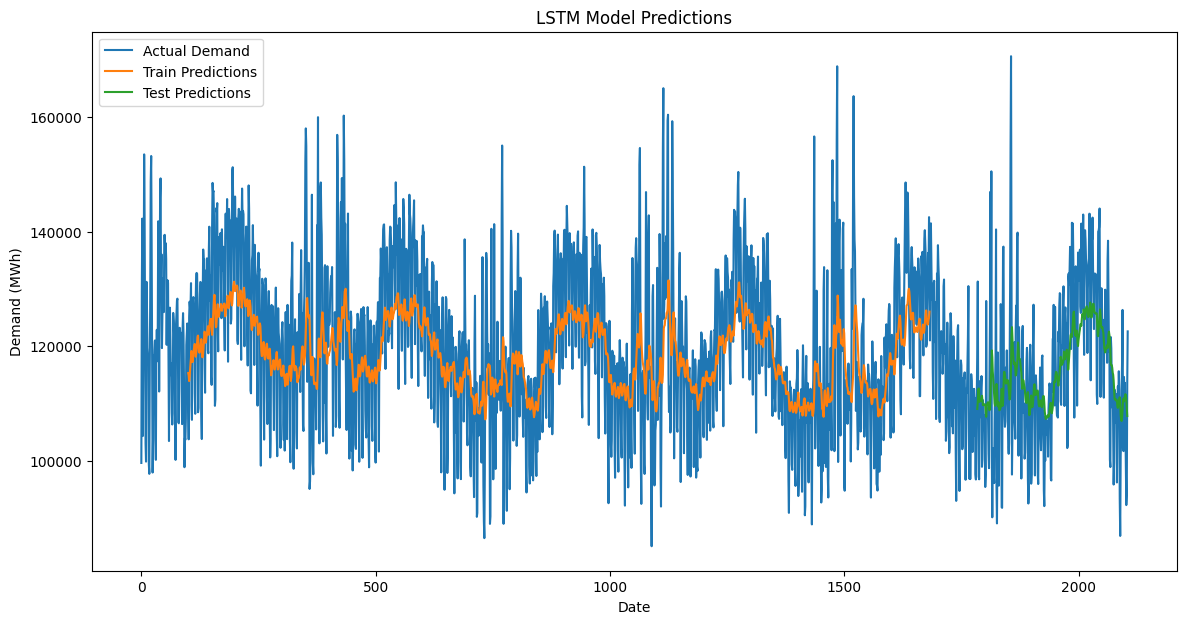

Train MAE: 9800.243357943777
Train MSE: 144364298.5211469
Train RMSE: 12015.169516954262
Test MAE: 9145.349794587228
Test MSE: 135440790.0713089
Test RMSE: 11637.903164716095


In [13]:
# Preparing the data for LSTM
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data_lstm = scaler_lstm.fit_transform(data[['demand']])

# Splitting the data into training and test sets
train_size_lstm = int(len(scaled_data_lstm) * 0.8)
train_data_lstm, test_data_lstm = scaled_data_lstm[:train_size_lstm], scaled_data_lstm[train_size_lstm:]

# Creating the dataset for LSTM
def create_dataset_lstm(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step_lstm = 100
X_train_lstm, Y_train_lstm = create_dataset_lstm(train_data_lstm, time_step_lstm)
X_test_lstm, Y_test_lstm = create_dataset_lstm(test_data_lstm, time_step_lstm)

# Reshaping the input to be [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step_lstm, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compiling the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
lstm_model.fit(X_train_lstm, Y_train_lstm, batch_size=1, epochs=1)

# Making predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)

# Transforming back to the original scale
lstm_train_pred_inv = scaler_lstm.inverse_transform(lstm_train_pred)
lstm_test_pred_inv = scaler_lstm.inverse_transform(lstm_test_pred)
Y_train_lstm_inv = scaler_lstm.inverse_transform([Y_train_lstm])
Y_test_lstm_inv = scaler_lstm.inverse_transform([Y_test_lstm])

# Plotting the results
train_predict_plot_lstm = np.empty_like(scaled_data_lstm)
train_predict_plot_lstm[:, :] = np.nan
train_predict_plot_lstm[time_step_lstm:len(lstm_train_pred_inv) + time_step_lstm, :] = lstm_train_pred_inv

test_predict_plot_lstm = np.empty_like(scaled_data_lstm)
test_predict_plot_lstm[:, :] = np.nan
test_predict_plot_lstm[len(lstm_train_pred_inv) + (time_step_lstm * 2) + 1:len(scaled_data_lstm) - 1, :] = lstm_test_pred_inv

plt.figure(figsize=(14, 7))
plt.plot(scaler_lstm.inverse_transform(scaled_data_lstm), label='Actual Demand')
plt.plot(train_predict_plot_lstm, label='Train Predictions')
plt.plot(test_predict_plot_lstm, label='Test Predictions')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# Calculate MAE, MSE, and RMSE for Train and Test sets
mae_train_lstm = mean_absolute_error(Y_train_lstm_inv[0], lstm_train_pred_inv)
mse_train_lstm = mean_squared_error(Y_train_lstm_inv[0], lstm_train_pred_inv)
rmse_train_lstm = np.sqrt(mse_train_lstm)

mae_test_lstm = mean_absolute_error(Y_test_lstm_inv[0], lstm_test_pred_inv)
mse_test_lstm = mean_squared_error(Y_test_lstm_inv[0], lstm_test_pred_inv)
rmse_test_lstm = np.sqrt(mse_test_lstm)

print(f'Train MAE: {mae_train_lstm}')
print(f'Train MSE: {mse_train_lstm}')
print(f'Train RMSE: {rmse_train_lstm}')

print(f'Test MAE: {mae_test_lstm}')
print(f'Test MSE: {mse_test_lstm}')
print(f'Test RMSE: {rmse_test_lstm}')

In [14]:
# Contextualizing the errors as a percentage of mean demand
mean_demand_lstm = data['demand'].mean()

train_mae_pct = mae_train_lstm / mean_demand_lstm * 100
train_rmse_pct = rmse_train_lstm / mean_demand_lstm * 100
test_mae_pct = mae_test_lstm / mean_demand_lstm * 100
test_rmse_pct = rmse_test_lstm / mean_demand_lstm * 100

print(f'Mean Demand: {mean_demand_lstm}')
print(f'Train MAE as a Percentage of Mean Demand: {train_mae_pct:.2f}%')
print(f'Train RMSE as a Percentage of Mean Demand: {train_rmse_pct:.2f}%')
print(f'Test MAE as a Percentage of Mean Demand: {test_mae_pct:.2f}%')
print(f'Test RMSE as a Percentage of Mean Demand: {test_rmse_pct:.2f}%')

Mean Demand: 120035.47650284901
Train MAE as a Percentage of Mean Demand: 8.16%
Train RMSE as a Percentage of Mean Demand: 10.01%
Test MAE as a Percentage of Mean Demand: 7.62%
Test RMSE as a Percentage of Mean Demand: 9.70%




> The LSTM model performs reasonably well, with prediction errors constituting a small percentage of the overall mean demand. Given the complexity and scale of the electricity demand data, these errors are acceptable. However, further tuning of the model parameters or incorporating additional features might help reduce the errors further.



## Final Conclusion of the Project

In this project, we aimed to forecast electricity demand using three different time series forecasting models: ARIMA, Prophet, and LSTM. Each model was evaluated using various performance metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). Here are the key findings and conclusions based on the results from each model:

1. **The ARIMA model** resulted in relatively high error values. Given the complexity of the electricity demand data and its inherent seasonality and trend components, the ARIMA model struggled to capture these patterns effectively. The high MAE and RMSE values indicate significant deviations between the predicted and actual values.

2. **The Prophet model** performed significantly better than the ARIMA model. The MAE and RMSE values were much lower, indicating more accurate predictions. The MAPE of 5.98% shows that the average prediction error was less than 6% of the actual values, which is relatively good. Additionally, the error metrics as percentages of the mean demand further validate the model's performance, making Prophet a strong contender for capturing the seasonality and trends in the electricity demand data.

3. **The LSTM model** also showed good performance, with MAE and RMSE values comparable to those of the Prophet model. The slight difference between the training and test errors indicates that the model generalizes well to unseen data. The LSTM model is particularly adept at capturing complex, non-linear relationships in the data, which might be why it performs well in this context.

> Overall Comparison and Recommendation
Based on the results from the three models, the Prophet model stands out as the best performer in terms of balancing simplicity, interpretability, and accuracy. Here’s a summary of the key points:
>
* ARIMA: Struggled to capture the complexity of the data, resulting in high error metrics.
* Prophet: Provided the most accurate predictions with relatively low error metrics and a high level of interpretability. Its ability to handle seasonality and trend components makes it a strong choice for this dataset.
* LSTM: Showed comparable performance to Prophet but with slightly higher error metrics. While powerful, the LSTM model is more complex and may require more resources for training and fine-tuning.